PS: this code was copied "as it was" from [here][1]. Obviously, it is not configured and the notebook output are not correct. See the beforementioned link for more details.

[1]: https://stanford.edu/~boyd/papers/prox_algs/lasso.html#8


In [1]:
function h = lasso

Continuation prompt found - input was incomplete:
function h = lasso


## Problem data

In [2]:
s = RandStream.create('mt19937ar','seed',0);
RandStream.setDefaultStream(s);

m = 500;       % number of examples
n = 2500;      % number of features

x0 = sprandn(n,1,0.05);
A = randn(m,n);
A = A*spdiags(1./sqrt(sum(A.^2))',0,n,n); % normalize columns
v = sqrt(0.001)*randn(m,1);
b = A*x0 + v;

fprintf('solving instance with %d examples, %d variables\n', m, n);
fprintf('nnz(x0) = %d; signal-to-noise ratio: %.2f\n', nnz(x0), norm(A*x0)^2/norm(v)^2);

gamma_max = norm(A'*b,'inf');
gamma = 0.1*gamma_max;

% cached computations for all methods
AtA = A'*A;
Atb = A'*b;

error: 'RandStream' undefined near line 1, column 1

The 'RandStream' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.
error: 'RandStream' undefined near line 1, column 1

The 'RandStream' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.
solving instance with 500 examples, 2500 variables
nnz(x0) = 125; signal-to-noise ratio: 270.20


Global constants and defaults

In [3]:
MAX_ITER = 100;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

## CVX

In [5]:
tic

cvx_begin quiet
    cvx_precision low
    variable x(n)
    minimize(0.5*sum_square(A*x - b) + gamma*norm(x,1))
cvx_end

h.x_cvx = x;
h.p_cvx = cvx_optval;
h.cvx_toc = toc;

error: 'cvx_begin' undefined near line 1, column 1
error: 'cvx_precision' undefined near line 1, column 1
error: 'variable' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1
error: 'cvx_end' undefined near line 1, column 1
error: 'x' undefined near line 1, column 1
error: 'cvx_optval' undefined near line 1, column 1


Proximal gradient

In [6]:
f = @(u) 0.5*sum_square(A*u-b);
lambda = 1;
beta = 0.5;

tic;

x = zeros(n,1);
xprev = x;

for k = 1:MAX_ITER
    while 1
        grad_x = AtA*x - Atb;
        z = prox_l1(x - lambda*grad_x, lambda*gamma);
        if f(z) <= f(x) + grad_x'*(z - x) + (1/(2*lambda))*sum_square(z - x)
            break;
        end
        lambda = beta*lambda;
    end
    xprev = x;
    x = z;

    h.prox_optval(k) = objective(A, b, gamma, x, x);
    if k > 1 && abs(h.prox_optval(k) - h.prox_optval(k-1)) < ABSTOL
        break;
    end
end

h.x_prox = x;
h.p_prox = h.prox_optval(end);
h.prox_grad_toc = toc;

error: 'prox_l1' undefined near line 4, column 4
error: structure has no member 'prox_optval'


## Fast proximal gradient

In [7]:
lambda = 1;

tic;

x = zeros(n,1);
xprev = x;
for k = 1:MAX_ITER
    y = x + (k/(k+3))*(x - xprev);
    while 1
        grad_y = AtA*y - Atb;
        z = prox_l1(y - lambda*grad_y, lambda*gamma);
        if f(z) <= f(y) + grad_y'*(z - y) + (1/(2*lambda))*sum_square(z - y)
            break;
        end
        lambda = beta*lambda;
    end
    xprev = x;
    x = z;

    h.fast_optval(k) = objective(A, b, gamma, x, x);
    if k > 1 && abs(h.fast_optval(k) - h.fast_optval(k-1)) < ABSTOL
        break;
    end
end

h.x_fast = x;
h.p_fast = h.fast_optval(end);
h.fast_toc = toc;

error: 'prox_l1' undefined near line 5, column 5
error: structure has no member 'fast_optval'


ADMM

In [8]:
lambda = 1;
rho = 1/lambda;

tic;

x = zeros(n,1);
z = zeros(n,1);
u = zeros(n,1);

[L U] = factor(A, rho);

for k = 1:MAX_ITER

    % x-update
    q = Atb + rho*(z - u);
    if m >= n
       x = U \ (L \ q);
    else
       x = lambda*(q - lambda*(A'*(U \ ( L \ (A*q) ))));
    end

    % z-update
    zold = z;
    z = prox_l1(x + u, lambda*gamma);

    % u-update
    u = u + x - z;

    % diagnostics, reporting, termination checks
    h.admm_optval(k)   = objective(A, b, gamma, x, z);
    h.r_norm(k)   = norm(x - z);
    h.s_norm(k)   = norm(-rho*(z - zold));
    h.eps_pri(k)  = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z));
    h.eps_dual(k) = sqrt(n)*ABSTOL + RELTOL*norm(rho*u);

    if h.r_norm(k) < h.eps_pri(k) && h.s_norm(k) < h.eps_dual(k)
         break;
    end

end

h.x_admm = z;
h.p_admm = h.admm_optval(end);
h.admm_toc = toc;

error: Invalid call to factor.  Correct usage is:

 -- PF = factor (Q)
 -- [PF, N] = factor (Q)

Additional help for built-in functions and operators is
available in the online version of the manual.  Use the command
'doc <topic>' to search the manual index.

Help and information about Octave is also available on the WWW
at https://www.octave.org and via the help@octave.org
mailing list.
error: 'U' undefined near line 8, column 8
error: structure has no member 'admm_optval'


## Timing

In [9]:
fprintf('CVX time elapsed: %.2f seconds.\n', h.cvx_toc);
fprintf('Proximal gradient time elapsed: %.2f seconds.\n', h.prox_grad_toc);
fprintf('Fast prox gradient time elapsed: %.2f seconds.\n', h.fast_toc);
fprintf('ADMM time elapsed: %.2f seconds.\n', h.admm_toc);

CVX time elapsed: 0.04 seconds.
Proximal gradient time elapsed: 0.05 seconds.
Fast prox gradient time elapsed: 0.06 seconds.
ADMM time elapsed: 0.21 seconds.


## Plots

error: structure has no member 'prox_optval'
error: structure has no member 'fast_optval'
error: structure has no member 'admm_optval'
error: structure has no member 'prox_iter'
error: structure has no member 'p_cvx'
error: structure has no member 'prox_optval'
error: structure has no member 'fast_optval'
error: structure has no member 'admm_optval'
error: 'K' undefined near line 1, column 1
error: legend: no valid object to label
error: called from
    legend>parse_opts at line 762 column 7
    legend at line 206 column 8


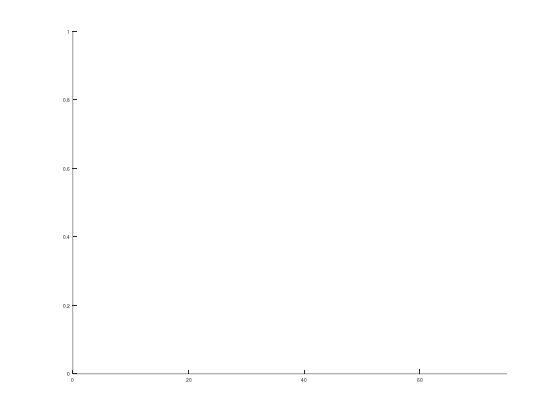

In [10]:
h.prox_iter = length(h.prox_optval);
h.fast_iter = length(h.fast_optval);
h.admm_iter = length(h.admm_optval);
K = max([h.prox_iter h.fast_iter h.admm_iter]);
h.cvx_optval  = h.p_cvx*ones(K,1);
h.prox_optval = padarray(h.prox_optval', K-h.prox_iter, h.p_prox, 'post');
h.fast_optval = padarray(h.fast_optval', K-h.fast_iter, h.p_fast, 'post');
h.admm_optval = padarray(h.admm_optval', K-h.admm_iter, h.p_admm, 'post');
fig = figure;

plot(1:K, h.cvx_optval,  'k--', ...
     1:K, h.prox_optval, 'r-', ...
     1:K, h.fast_optval, 'g-', ...
     1:K, h.admm_optval, 'b-');

xlim([0 75]);
legend('True', 'Proximal gradient', 'Accelerated', 'ADMM');
print -depsc lasso_comp.eps;
end

function p = objective(A, b, gamma, x, z)
    p = 0.5*sum_square(A*x - b) + gamma*norm(z,1);
end

function [L U] = factor(A, rho)
    [m, n] = size(A);
    if m >= n
       L = chol(A'*A + rho*speye(n), 'lower');
    else
       L = chol(speye(m) + 1/rho*(A*A'), 'lower');
    end
    L = sparse(L);
    U = sparse(L');
end